NameError: name 'tpe' is not defined

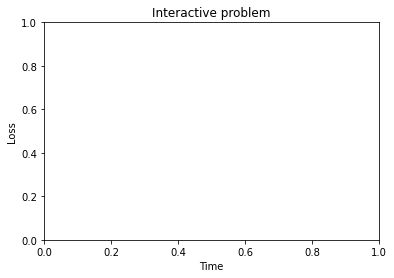

In [1]:
import numpy as np
import time
from Helper import LearningCurvePlot, smooth

def average_over_repetitions(smoothing_window, plot, n_repetitions, method, n_episodes, gamma, problem, rwarmup):
    losses_results = np.empty([n_repetitions,n_episodes]) # Losses array
    now = time.time()
    
    if method == 'tpe':
        G = tpe
    else:
        G = random_search
    
    for rep in range(n_repetitions): # Loop over repetitions
        losses, configs = G(problem = problem, function_evaluations=n_episodes, random_warmup=rwarmup, gamma=gamma)
        losses_results[rep] = losses
    
    print('Running one setting takes {} minutes'.format((time.time()-now)/60))
    learning_curve = np.mean(losses_results,axis=0) # average over repetitions
    print('Employing the ' + method + ' method on the ' + problem + ' problem, we obtain an average best loss of: ' + str(min(learning_curve)))
    learning_curve = smooth(learning_curve,smoothing_window) # additional smoothing
    return learning_curve

def experiment():
    ####### Settings
    # Experiment    
    n_repetitions = 20
    smoothing_window = 24
    n_episodes = 150
    gammas = [0.1, 0.3, 0.5, 0.7, 0.9]
    problems = ['interactive']
    methods = ['tpe','rse']
    rwarmup = 10
    gamma = 0.1
    
    # Plotting parameters
    plot = True
    
    # Nice labels for plotting
    labels = {'interactive': 'Interactive', 'good_range': 'Good range', 'bad_range': 'Bad range', 'rs': 'random search',
             'tpe': 'tpe'}

    
    ####### Experiments
        
    #problem = 'interactive'
    method = 'tpe'
    #Plot1 = LearningCurvePlot(title = labels[problem] + ' problem solved with ' + labels[method])
    
    for problem in problems:
        Plot1 = LearningCurvePlot(title = labels[problem] + ' problem')
        for gamma in gammas:
            learning_curve = average_over_repetitions(smoothing_window, plot, n_repetitions, method,
                                                          n_episodes, gamma, problem, rwarmup)
            Plot1.add_curve(learning_curve,label = 'test gamma: ' + str(gamma))
        Plot1.save('test_' + labels[method] + '_' + labels[problem] + '.png')

if __name__ == '__main__':
    experiment()


In [3]:
def random_search(problem, function_evaluations=150, **kwargs):
    """
    Function that performs random search on the given problem. It uses the 
    ranges and sampling types defined in GET_RANGES(problem) (see utils.py).

    Arguments:
      - problem (str): the prolbem identifier
      - function_evaluations (int): the number of configurations to evaluate
      - **kwargs: any other keyword arguments 

    Returns:
      - history (list): A list of the observed losses
      - configs (list): A list of the tried configurations. Every configuration is a dictionary
                        mapping hyperparameter names to the chosen values 
    """

    history = []
    configs = []

    # get all information about the hyperparameters we want to tune for this problem
    # (see utils.py) for the form of this.  
    RANGES = GET_RANGES(problem) 

    # example of a hyperparameter configuration. you of course want to change the names and values
    # according to the problem and the values you sample
    config = {}

    for hyperparameter in RANGES:
        set_range = RANGES[hyperparameter]['range']
        set_type = RANGES[hyperparameter]['type']
        set_sample = RANGES[hyperparameter]['sample']
        
        if set_type == 0:
            config[hyperparameter] = np.random.choice(set_range)
        if set_type == 1:
            if set_sample == 0:
                config[hyperparameter] = np.random.uniform(RANGES[hyperparameter]['range'][0], RANGES[hyperparameter]['range'][1])
            if set_sample == 1:
                config[hyperparameter] = np.exp(np.random.uniform(np.log(RANGES[hyperparameter]['range'][0]), np.log(RANGES[hyperparameter]['range'][1])))
        if set_type == 2:
                if set_sample == 0:
                    config[hyperparameter] = round(np.random.uniform(RANGES[hyperparameter]['range'][0], RANGES[hyperparameter]['range'][1]))
                if set_sample == 1:
                    config[hyperparameter] = round(np.exp(np.random.uniform(np.log(RANGES[hyperparameter]['range'][0]), np.log(RANGES[hyperparameter]['range'][1]))))
            
    configs += [config]
    
    # once you have a configuration 'config' in the form of a dictionary mapping from 
    # hyperparameter -> value you can evaluate it using this function
    loss = GET_CONFIG_PERFORMANCE(config, problem)
    history += [loss]

    # TODO: implement the rest of the function
    for step in range(function_evaluations - 1):
        config = {}

        for hyperparameter in RANGES:
            set_range = RANGES[hyperparameter]['range']
            set_type = RANGES[hyperparameter]['type']
            set_sample = RANGES[hyperparameter]['sample']
            
            if set_type == 0:
                config[hyperparameter] = np.random.choice(set_range)
            if set_type == 1:
                if set_sample == 0:
                    config[hyperparameter] = np.random.uniform(RANGES[hyperparameter]['range'][0], RANGES[hyperparameter]['range'][1])
                if set_sample == 1:
                    config[hyperparameter] = np.exp(np.random.uniform(np.log(RANGES[hyperparameter]['range'][0]), np.log(RANGES[hyperparameter]['range'][1])))
            if set_type == 2:
                if set_sample == 0:
                    config[hyperparameter] = round(np.random.uniform(RANGES[hyperparameter]['range'][0], RANGES[hyperparameter]['range'][1]))
                if set_sample == 1:
                    config[hyperparameter] = round(np.exp(np.random.uniform(np.log(RANGES[hyperparameter]['range'][0]), np.log(RANGES[hyperparameter]['range'][1]))))
                
        configs += [config]
        
        #report loss
        loss = GET_CONFIG_PERFORMANCE(config, problem)
        history += [loss]

    
    return history, configs


def tpe(problem, function_evaluations=150, random_warmup=30, gamma=0.2, **kwargs):
    """
    Function that uses Tree Parzen Estimator (TPE) to tune the hyperparameters of the 
    given problem. It uses the ranges and sampling types defined in GET_RANGES(problem) 
    (see utils.py).

    Arguments:
      - problem (str): the problem identifier
      - function_evaluations (int): the number of configurations to evaluate
      - random_warmup (int): the number of initial iterations during which we perform random 
                             search
      - gamma: the value of gamma that determines the cutting point [good partition, bad partition]
      - **kwargs: any other keyword arguments 

    Returns:
      - history (list): A list of the observed losses
      - configs (list): A list of the tried configurations. Every configuration is a dictionary
                        mapping hyperparameter names to the chosen values 
    """

    history = []
    configs = []
    eps = 1e-250

    # define a function to sum different pdf of truncated normal distributions with same shape and same scale
    def sum_pdf(x, means, myclip_a, myclip_b):
        tot_sum = 0
        ordered_means = sorted(means)
        for i in range(len(ordered_means)):
            m = ordered_means[i]
            # as in the original paper, the scale is defined as the maximum distance between the left and right neighbours,
            # but clipped to remain less than 1 and bigger than 0.01
            scale = min(max(m - ordered_means[max(i-1,0)], ordered_means[min(i+1, len(means)-1)] - m, 0.01), 0.5) + eps
            a, b = (myclip_a - m) / scale, (myclip_b - m) / scale
            tot_sum += truncnorm.pdf(x, a, b, loc = m, scale = scale)/len(means)
        return tot_sum

    # define a function to take samples from a mixture of truncated normal distributions with same shape ans same scale
    def sample_from_mixture(means, myclip_a, myclip_b, size):
        samples = []
        ordered_means = sorted(means)
        for j in range(size):
            i = np.random.choice(range(len(means)))
            m = ordered_means[i]
            scale = min(max(m - ordered_means[max(i-1,0)], ordered_means[min(i+1, len(means)-1)] - m), 1) + eps
            a, b = (myclip_a - m) / scale, (myclip_b - m) / scale
            chosen_distribution = truncnorm(a, b, loc = m, scale = scale)
            sampled_value = chosen_distribution.rvs()
            samples += [sampled_value]
        return samples
                                               
    # get all information about the hyperparameters we want to tune for this problem
    # (see utils.py) for the form of this.  
    RANGES = GET_RANGES(problem) 

    # example of a hyperparameter configuration. you of course want to change the names and values
    # according to the problem and the values you sample
    history_warmup, configs_warmup = random_search(problem, random_warmup)
    history += history_warmup
    configs += configs_warmup

    for step in range(function_evaluations - random_warmup):
        config = {}

        for hyperparameter in RANGES:
            values = [c[hyperparameter] for c in configs if hyperparameter in c]
            losses = [history[i] for i in range(len(configs)) if hyperparameter in configs[i]]
            ordering_permutation = np.argsort(losses)
            ordered_values = [values[i] for i in ordering_permutation]
            good_values = values[0: round(len(values)*gamma)]
            bad_values = values[round(len(values)*gamma):]
            set_range = RANGES[hyperparameter]['range']
            set_type = RANGES[hyperparameter]['type']
            set_sample = RANGES[hyperparameter]['sample']
            myclip_a = RANGES[hyperparameter]['range'][0]
            myclip_b = RANGES[hyperparameter]['range'][1]
            
            # the following line checks whether conditional hyperparameters should be considered
            if (problem!='interactive') & (RANGES[hyperparameter]['type']==2):
                if not RANGES[hyperparameter]['condition']({'nlayers':condition}):
                    continue
                        
            if set_type == 0:
                occurrences_vector = [good_values.count(value)/(bad_values.count(value) + eps) for value in set_range]
                index = np.argmax(occurrences_vector)
                config[hyperparameter] = set_range[index]
            if set_type == 1:
                if set_sample == 0:
                    def f(x):
                        return sum_pdf(x, means = np.array(good_values,dtype=float), myclip_a = myclip_a,
                                        myclip_b = myclip_b)/(sum_pdf(x, means =np.array(bad_values,dtype=float),
                                                                      myclip_a = myclip_a, myclip_b = myclip_b))
                    #config[hyperparameter] = scipy.optimize.minimize(f, (myclip_a + myclip_b)/2)['x'][0]
                    sampled_points = sample_from_mixture(good_values, myclip_a, myclip_b, 50)
                    index = np.argmax(f(np.array(sampled_points)))
                    config[hyperparameter] = sampled_points[index]
                if set_sample == 1:
                    def f(x):
                        return -sum_pdf(x, means = np.log(np.array(good_values,dtype=float)), myclip_a = np.log(myclip_a),
                                        myclip_b = np.log(myclip_b))/(sum_pdf(x,
                                means = np.log(np.array(bad_values,
                                dtype=float)), myclip_a = np.log(myclip_a), myclip_b = np.log(myclip_b)) + eps)
                    config[hyperparameter] = np.exp(scipy.optimize.minimize(f,
                    (np.log(myclip_a) + np.log(myclip_b))/2)['x'][0])
            if set_type == 2:
                if set_sample == 0:
                    def f(x):
                        return -sum_pdf(x, means = np.array(good_values,dtype=float), myclip_a = myclip_a, 
                                        myclip_b = myclip_b)/(sum_pdf(x, means =np.array(bad_values,dtype=float), 
                                        myclip_a = myclip_a, myclip_b = myclip_b) + eps)
                    config[hyperparameter]=round(scipy.optimize.minimize(f,(myclip_a + myclip_b)/2)['x'][0])
            
                if set_sample == 1:
                    def f(x):
                        return -sum_pdf(x, means = np.log(np.array(good_values,dtype=float)),myclip_a=np.log(myclip_a), 
                                        myclip_b = np.log(myclip_b))/(sum_pdf(x, means = np.log(np.array(bad_values,dtype=float)), 
                                        myclip_a = np.log(myclip_a), myclip_b = np.log(myclip_b)) + eps)
                    config[hyperparameter] = round(np.exp(scipy.optimize.minimize(
                        f, (np.log(myclip_a) + np.log(myclip_b))/2)['x'][0]))
             
            # this is necessary to tell whether the conditional hyperparameters should be considered or not
            if hyperparameter == 'nlayers':
                condition = config[hyperparameter]
                
        configs += [config]
        
        #report loss
        loss = GET_CONFIG_PERFORMANCE(config, problem)
        history += [loss]
        
    return history, configs

In [4]:
import numpy as np
import argparse
import os
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import truncnorm
import scipy
from utils import GET_CONFIG_PERFORMANCE, GET_RANGES, SampleType, ParamType # make sure to make use of ParamType and SampleType in your code
